In [3]:
#package
import pandas as pd
import numpy as np
from pandas import Series,DataFrame

import spacy
import string
from nltk.corpus import stopwords
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
import unicodedata

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# Load data
path = 'D:/USA 2021 Spring/Data_science/train.csv'
traindf = pd.read_csv(path)

In [5]:
path = 'D:/USA 2021 Spring/Data_science/test.csv'
testdf = pd.read_csv(path)

In [6]:
display(traindf.head(), testdf.head())

,review_id,review,rating
0,0,Ga disappointed neat products .. Meletot Hilsn...,1
1,1,"Rdtanya replace broken glass, broken chargernya",1
2,2,Nyesel bngt dsni shopping antecedent photo mes...,1
3,3,Sent a light blue suit goods ga want a refund,1
4,4,Pendants came with dents and scratches on its ...,1


,review_id,review
0,1,"Great danger, cool, motif and cantik2 jg model..."
1,2,One of the shades don't fit well
2,3,Very comfortable
3,4,Fast delivery. Product expiry is on Dec 2022. ...
4,5,it's sooooo cute! i like playing with the glit...


# Step 1 Exploration and Data Clean

## Data information

In [7]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146811 entries, 0 to 146810
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review_id  146811 non-null  int64 
 1   review     146811 non-null  object
 2   rating     146811 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [8]:
traindf["rating"].value_counts()

4    41865
5    41515
3    35941
1    14785
2    12705
Name: rating, dtype: int64

## Text Pre-processing

In [9]:
from sklearn.model_selection import train_test_split

msg_train,msg_valid,rating_train,rating_valid = train_test_split(traindf['review'],traindf['rating'])

print(len(msg_train), len(rating_train), len(msg_valid),len(rating_valid))

110108 110108 36703 36703


In [91]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le_train = le.fit_transform(rating_train)
train_Y = np_utils.to_categorical(le_train)

le_valid = le.fit_transform(rating_valid)
valid_Y =np_utils.to_categorical(le_valid)

In [107]:
train_Y

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [10]:
# normalize
## remove negation words from stopword_list
nlp = spacy.load('en_core_web_lg')
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [11]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text
def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters    
        if special_char_removal:
            doc = remove_special_characters(doc)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [12]:
norm_train_msg = normalize_corpus(msg_train, html_stripping=False)
norm_valid_msg = normalize_corpus(msg_valid, html_stripping=False)

In [13]:
norm_train_msg[0]

'okay well price quality product everything fine I know film not full screen one leave I okay well price quality product everything fine I know film not full screen one leave I'

In [14]:
# encode: word to index
##Tokenize
tokenized_train = [tokenizer.tokenize(text) for text in norm_train_msg]
tokenized_valid = [tokenizer.tokenize(text) for text in norm_valid_msg]

In [15]:
tokenized_train[0]

['okay',
 'well',
 'price',
 'quality',
 'product',
 'everything',
 'fine',
 'I',
 'know',
 'film',
 'not',
 'full',
 'screen',
 'one',
 'leave',
 'I',
 'okay',
 'well',
 'price',
 'quality',
 'product',
 'everything',
 'fine',
 'I',
 'know',
 'film',
 'not',
 'full',
 'screen',
 'one',
 'leave',
 'I']

In [16]:
## build encode list
from collections import Counter
token_counter = Counter([token for review in tokenized_train for token in review])
vocab_map = {item[0]: index+1 for index, item in enumerate(dict(token_counter).items())}
max_index = np.max(list(vocab_map.values()))
vocab_map['PAD_INDEX'] = 0
vocab_map['NOT_FOUND_INDEX'] = max_index+1
vocab_size = len(vocab_map)

print('Vocabulary Size:', vocab_size)
print('Sample slice of vocabulary map:', dict(list(vocab_map.items())[10:20]))

Vocabulary Size: 47690
Sample slice of vocabulary map: {'not': 11, 'full': 12, 'screen': 13, 'one': 14, 'leave': 15, 'excellent': 16, 'good': 17, 'delivery': 18, 'speed': 19, 'seller': 20}


In [17]:
## Convert tokenized text reviews to numeric vectors
from keras.preprocessing import sequence
max_len = np.max([len(review) for review in tokenized_train])
train_X = [[vocab_map[token] for token in tokenized_review] for tokenized_review in tokenized_train]
train_X = sequence.pad_sequences(train_X, maxlen=max_len)

valid_X = [[vocab_map[token] if vocab_map.get(token) else vocab_map['NOT_FOUND_INDEX'] 
           for token in tokenized_review] 
              for tokenized_review in tokenized_valid]
valid_X = sequence.pad_sequences(valid_X, maxlen=max_len)

In [18]:
train_X[3000]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [19]:
print('Max length of train review vectors:', max_len)
print('Train review vectors shape:', train_X.shape,'Valid review vectors shape:', valid_X.shape)

Max length of train review vectors: 176
Train review vectors shape: (110108, 176) Valid review vectors shape: (36703, 176)


# Step2 Modeling

In [29]:
from sklearn import metrics
def train_predict_model(classifier, 
                        train_features, train_labels, 
                        test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    return predictions 

In [21]:
def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))

In [22]:
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)

In [23]:
def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    #level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels)
    cm_frame = pd.DataFrame(data=cm, 
                            index = [['Actual']*total_classes,classes],
                            columns = [['Predicted']*total_classes,classes]) 
    print (cm_frame)

In [24]:
def display_model_performance_metrics(true_labels, predicted_labels, classes):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)

## logistic regression

In [25]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
lr = LogisticRegression(penalty='l2', max_iter=100, C=1)

In [26]:
print(len(train_X), len(rating_train), len(valid_X),len(rating_valid))

110108 110108 36703 36703


In [27]:
lr_predictions = train_predict_model(classifier=lr, 
                                         train_features=train_X, train_labels=rating_train,
                                         test_features=valid_X, test_labels=rating_valid)


C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [30]:
display_model_performance_metrics(true_labels=rating_valid, predicted_labels=lr_predictions,
                                      classes=[1,2,3,4,5])

Model Performance metrics:
------------------------------
Accuracy: 0.2804
Precision: 0.2542
Recall: 0.2804
F1 Score: 0.2334

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.20      0.04      0.07      3645
           2       0.15      0.00      0.00      3173
           3       0.24      0.12      0.16      8982
           4       0.29      0.62      0.40     10495
           5       0.28      0.25      0.26     10408

    accuracy                           0.28     36703
   macro avg       0.23      0.21      0.18     36703
weighted avg       0.25      0.28      0.23     36703


Prediction Confusion Matrix:
------------------------------
         Predicted                      
                 1   2     3     4     5
Actual 1       154  11   498  2062   920
       2        94   6   413  1870   790
       3       195   7  1048  5413  2319
       4       188  10  1158  6524  2615
       5       152

## SVM

In [31]:
svm = SGDClassifier(loss='hinge', max_iter=100)

In [32]:
svm_predictions = train_predict_model(classifier=svm, 
                                             train_features=train_X, train_labels=rating_train,
                                             test_features=valid_X, test_labels=rating_valid)
display_model_performance_metrics(true_labels=rating_valid, predicted_labels=svm_predictions,
                                      classes=[1,2,3,4,5])

Model Performance metrics:
------------------------------
Accuracy: 0.2222
Precision: 0.2382
Recall: 0.2222
F1 Score: 0.2066

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.12      0.13      0.12      3645
           2       0.11      0.14      0.13      3173
           3       0.24      0.48      0.32      8982
           4       0.29      0.15      0.20     10495
           5       0.26      0.13      0.17     10408

    accuracy                           0.22     36703
   macro avg       0.20      0.21      0.19     36703
weighted avg       0.24      0.22      0.21     36703


Prediction Confusion Matrix:
------------------------------
         Predicted                        
                 1     2     3     4     5
Actual 1       465   494  1668   514   504
       2       409   458  1589   337   380
       3       922   937  4317  1397  1409
       4      1063  1156  5276  1585  1415
      

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [53]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Activation, SpatialDropout1D, GlobalAveragePooling1D
from keras.layers import LSTM
from keras.layers.normalization import BatchNormalization

## DNN

In [1]:
def construct_deepnn_architecture(num_input_features):
    dnn_model = Sequential()
    dnn_model.add(Embedding(num_input_features,128))
    dnn_model.add(GlobalAveragePooling1D())
    dnn_model.add(Dense(64, activation="relu"))
    dnn_model.add(Dense(32, activation="relu"))
    dnn_model.add(Dense(5, activation="softmax"))

    dnn_model.compile(loss='categorical_crossentropy', optimizer='adam',                 
                      metrics=['accuracy'])
    return dnn_model

In [126]:
dnn_embedding = construct_deepnn_architecture(num_input_features=len(train_Y))

In [127]:
print(dnn_embedding.summary())

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 128)         14093824  
_________________________________________________________________
global_average_pooling1d_10  (None, 128)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_65 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_66 (Dense)             (None, 5)                 165       
Total params: 14,104,325
Trainable params: 14,104,325
Non-trainable params: 0
_________________________________________________________________
None


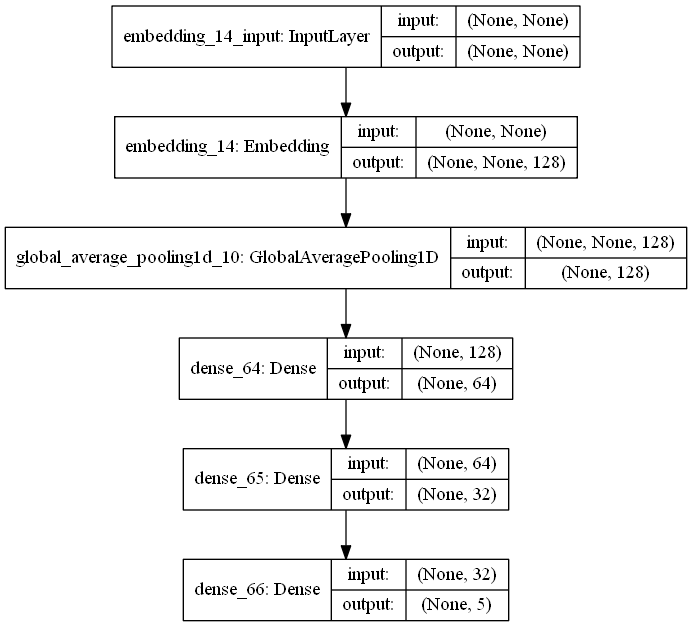

In [128]:
from keras.utils.vis_utils import plot_model
plot_model(dnn_embedding, to_file='dmm_model.png', show_shapes=True, show_layer_names=True)

In [129]:
batch_size = 100
dnn_embedding.fit(train_X, train_Y, epochs=5, batch_size=batch_size, 
            shuffle=True, validation_split=0.1, verbose=1)
dnn_embedding

Train on 99097 samples, validate on 11011 samples
Epoch 1/10
99097/99097 [==============================] - 162s 2ms/step - loss: 1.3151 - accuracy: 0.3698 - val_loss: 1.1712 - val_accuracy: 0.4451
Epoch 2/10
99097/99097 [==============================] - 162s 2ms/step - loss: 1.1262 - accuracy: 0.4594 - val_loss: 1.1270 - val_accuracy: 0.4572
Epoch 3/10
99097/99097 [==============================] - 161s 2ms/step - loss: 1.0757 - accuracy: 0.4822 - val_loss: 1.1199 - val_accuracy: 0.4692
Epoch 4/10
99097/99097 [==============================] - 159s 2ms/step - loss: 1.0400 - accuracy: 0.4990 - val_loss: 1.1469 - val_accuracy: 0.4493
Epoch 5/10
99097/99097 [==============================] - 159s 2ms/step - loss: 1.0053 - accuracy: 0.5125 - val_loss: 1.1407 - val_accuracy: 0.4654
Epoch 6/10
99097/99097 [==============================] - 161s 2ms/step - loss: 0.9714 - accuracy: 0.5300 - val_loss: 1.1485 - val_accuracy: 0.4647
Epoch 7/10
99097/99097 [==============================] - 160s

In [130]:
y_pred = dnn_embedding.predict_classes(valid_X)
dnn_predictions = le.inverse_transform(y_pred)

In [131]:
display_model_performance_metrics(true_labels=rating_valid, predicted_labels=dnn_predictions,
                                      classes=[1,2,3,4,5])

Model Performance metrics:
------------------------------
Accuracy: 0.4497
Precision: 0.4536
Recall: 0.4497
F1 Score: 0.4487

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.58      0.62      0.60      3645
           2       0.45      0.26      0.33      3173
           3       0.53      0.50      0.52      8982
           4       0.37      0.42      0.40     10495
           5       0.42      0.44      0.43     10408

    accuracy                           0.45     36703
   macro avg       0.47      0.45      0.45     36703
weighted avg       0.45      0.45      0.45     36703


Prediction Confusion Matrix:
------------------------------
         Predicted                       
                 1    2     3     4     5
Actual 1      2248  355   570   396    76
       2       689  824  1014   410   236
       3       542  449  4473  2204  1314
       4       184   83  1157  4412  4659
       5    

## LSTM

In [136]:
def construct_lstm_architecture(num_input_features):
    lstm_model = Sequential()
    lstm_model.add(Embedding(input_dim=num_input_features, output_dim=128,input_length=max_len))
    lstm_model.add(SpatialDropout1D(0.2))
    lstm_model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    lstm_model.add(Dense(32, activation="relu"))
    lstm_model.add(Dense(5, activation="softmax"))

    lstm_model.compile(loss='categorical_crossentropy', optimizer='adam',                 
                      metrics=['accuracy'])
    return lstm_model

In [137]:
lstm_embedding = construct_lstm_architecture(num_input_features=vocab_size)

In [138]:
print(lstm_embedding.summary())

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 176, 128)          6104320   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 176, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_67 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_68 (Dense)             (None, 5)                 165       
Total params: 6,155,973
Trainable params: 6,155,973
Non-trainable params: 0
_________________________________________________________________
None


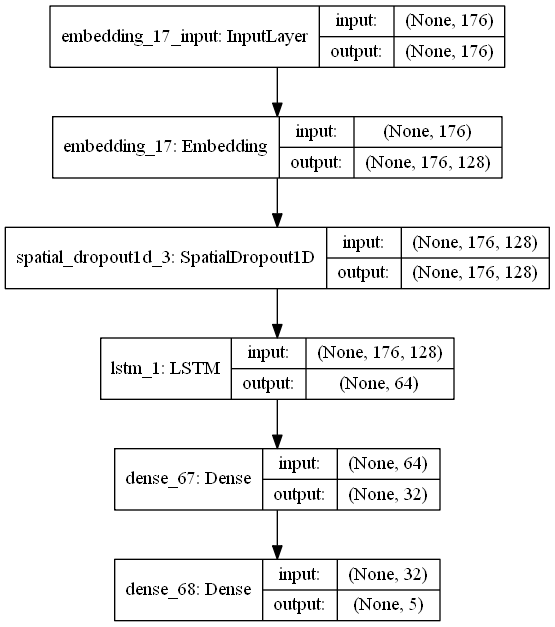

In [139]:
plot_model(lstm_embedding, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

In [140]:
batch_size = 100
lstm_embedding.fit(train_X, train_Y, epochs=10, batch_size=batch_size, 
            shuffle=True, validation_split=0.1, verbose=1)
lstm_embedding

Train on 99097 samples, validate on 11011 samples
Epoch 1/10
99097/99097 [==============================] - 306s 3ms/step - loss: 1.1767 - accuracy: 0.4343 - val_loss: 1.0940 - val_accuracy: 0.4701
Epoch 2/10
99097/99097 [==============================] - 312s 3ms/step - loss: 1.0360 - accuracy: 0.4992 - val_loss: 1.0860 - val_accuracy: 0.4788
Epoch 3/10
99097/99097 [==============================] - 313s 3ms/step - loss: 0.9608 - accuracy: 0.5391 - val_loss: 1.1049 - val_accuracy: 0.4766
Epoch 4/10
99097/99097 [==============================] - 311s 3ms/step - loss: 0.8922 - accuracy: 0.5809 - val_loss: 1.1517 - val_accuracy: 0.4693
Epoch 5/10
99097/99097 [==============================] - 315s 3ms/step - loss: 0.8275 - accuracy: 0.6143 - val_loss: 1.2029 - val_accuracy: 0.4643
Epoch 6/10
99097/99097 [==============================] - 312s 3ms/step - loss: 0.7701 - accuracy: 0.6418 - val_loss: 1.2649 - val_accuracy: 0.4639
Epoch 7/10
99097/99097 [==============================] - 312s

In [141]:
y_pred = lstm_embedding.predict_classes(valid_X)
lstm_predictions = le.inverse_transform(y_pred)

In [142]:
display_model_performance_metrics(true_labels=rating_valid, predicted_labels=lstm_predictions,
                                      classes=[1,2,3,4,5])

Model Performance metrics:
------------------------------
Accuracy: 0.4549
Precision: 0.4483
Recall: 0.4549
F1 Score: 0.4436

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.57      0.61      0.59      3645
           2       0.38      0.35      0.37      3173
           3       0.51      0.55      0.53      8982
           4       0.39      0.24      0.30     10495
           5       0.43      0.56      0.49     10408

    accuracy                           0.45     36703
   macro avg       0.46      0.46      0.45     36703
weighted avg       0.45      0.45      0.44     36703


Prediction Confusion Matrix:
------------------------------
         Predicted                        
                 1     2     3     4     5
Actual 1      2229   588   512   160   156
       2       656  1120   905   214   278
       3       576   798  4933  1125  1550
       4       216   197  1607  2544  5931
      

## LSTM + FastText

In [143]:
#https://github.com/emmanuellaanggi/disaster_tweet_sentiment/blob/master/(Medium)_Text_Classification_Disaster_Tweet_.ipynb
import requests, zipfile, io
zip_file_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [146]:
import codecs
from tqdm import tqdm

print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('crawl-300d-2M.vec', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

1927it [00:00, 9469.90it/s]

loading word embeddings...


1999996it [03:34, 9325.71it/s]

found 1999996 word vectors


In [148]:
MAX_NB_WORDS = 100000
embed_dim = 300 

In [149]:
#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(vocab_map)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in vocab_map.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 27830


In [150]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['talag' 'dineli' 'topppppppppp' 'dehdehdeh' 'kasiiiiiih' 'anlakas'
 'racun2' 'bklo' 'denganproduk' 'diexpedisinyaaaaaa']


In [162]:
def construct_lstm_embedding_architecture(num_input_features):
    lstm_em_model = Sequential()
    lstm_em_model.add(Embedding(input_dim=num_input_features, output_dim=embed_dim,
                                input_length=max_len, weights=[embedding_matrix],trainable=False))
    lstm_em_model.add(SpatialDropout1D(0.2))
    lstm_em_model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    lstm_em_model.add(Dense(32, activation="relu"))
    lstm_em_model.add(Dropout(0.4))
    lstm_em_model.add(Dense(5, activation="softmax"))

    lstm_em_model.compile(loss='categorical_crossentropy', optimizer='adam',                 
                      metrics=['accuracy'])
    return lstm_em_model

In [163]:
lstm_embedding_fast = construct_lstm_embedding_architecture(num_input_features=vocab_size+1)

In [164]:
print(lstm_embedding_fast.summary())

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 176, 300)          14307300  
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 176, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_69 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_37 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 5)                 165       
Total params: 14,402,985
Trainable params: 95,685
Non-trainable params: 14,307,300
____________________________________

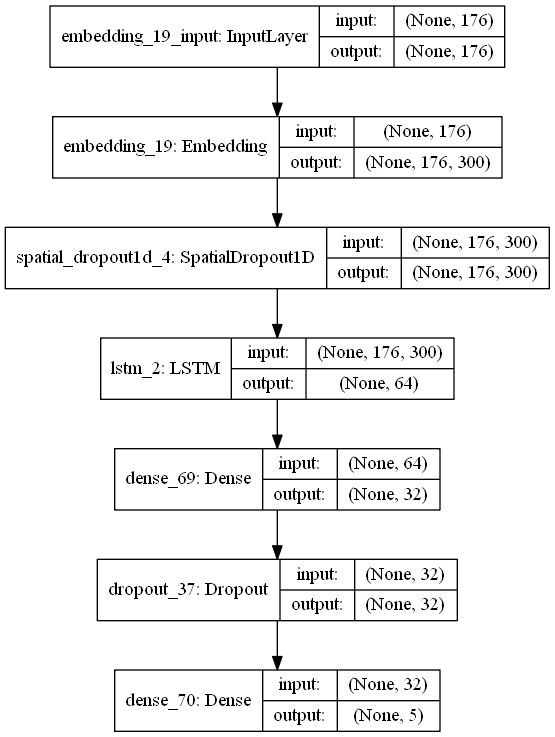

In [165]:
plot_model(lstm_embedding_fast, to_file='lstm_em_model.png', show_shapes=True, show_layer_names=True)

In [166]:
batch_size = 100
lstm_embedding_fast.fit(train_X, train_Y, epochs=10, batch_size=batch_size, 
            shuffle=True, validation_split=0.1, verbose=1)
lstm_embedding_fast

Train on 99097 samples, validate on 11011 samples
Epoch 1/10
99097/99097 [==============================] - 271s 3ms/step - loss: 1.2545 - accuracy: 0.4088 - val_loss: 1.1318 - val_accuracy: 0.4633
Epoch 2/10
99097/99097 [==============================] - 264s 3ms/step - loss: 1.1669 - accuracy: 0.4463 - val_loss: 1.1061 - val_accuracy: 0.4626
Epoch 3/10
99097/99097 [==============================] - 261s 3ms/step - loss: 1.1383 - accuracy: 0.4555 - val_loss: 1.0869 - val_accuracy: 0.4765
Epoch 4/10
99097/99097 [==============================] - 261s 3ms/step - loss: 1.1163 - accuracy: 0.4655 - val_loss: 1.0808 - val_accuracy: 0.4802
Epoch 5/10
99097/99097 [==============================] - 262s 3ms/step - loss: 1.1227 - accuracy: 0.4626 - val_loss: 1.0855 - val_accuracy: 0.4674
Epoch 6/10
99097/99097 [==============================] - 263s 3ms/step - loss: 1.1035 - accuracy: 0.4704 - val_loss: 1.0746 - val_accuracy: 0.4826
Epoch 7/10
99097/99097 [==============================] - 262s

In [167]:
y_pred = lstm_embedding_fast.predict_classes(valid_X)
lstm_em_predictions = le.inverse_transform(y_pred)

In [168]:
lstm_em_predictions

array([3, 4, 3, ..., 4, 4, 5], dtype=int64)

In [169]:
display_model_performance_metrics(true_labels=rating_valid, predicted_labels=lstm_em_predictions,
                                      classes=[1,2,3,4,5])

Model Performance metrics:
------------------------------
Accuracy: 0.4807
Precision: 0.4998
Recall: 0.4807
F1 Score: 0.4267

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.55      0.78      0.64      3645
           2       0.69      0.21      0.32      3173
           3       0.52      0.63      0.57      8982
           4       0.43      0.72      0.53     10495
           5       0.48      0.09      0.15     10408

    accuracy                           0.48     36703
   macro avg       0.53      0.49      0.44     36703
weighted avg       0.50      0.48      0.43     36703


Prediction Confusion Matrix:
------------------------------
         Predicted                      
                 1    2     3     4    5
Actual 1      2841   85   574   142    3
       2      1022  664  1194   285    8
       3       798  174  5670  2271   69
       4       258   24  1762  7538  913
       5       264

In [ ]:
#https://www.analyticsvidhya.com/blog/2015/10/6-practices-enhance-performance-text-classification-model/